In [ ]:
# --- 1. INSTALACIÓN DE LIBRERÍAS ---
!pip install catboost optuna imbalanced-learn shap -q
print("Librerías instaladas correctamente.")

^C


In [ ]:
# --- 2. IMPORTACIÓN DE LIBRERÍAS ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
import shap
import warnings

# Preprocesamiento y selección
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from imblearn.over_sampling import SMOTE

# Métricas
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report

# Modelos
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

warnings.filterwarnings('ignore')
print("Librerías importadas correctamente.")

In [2]:
# --- 3. CARGA Y PREPARACIÓN DE DATOS ---
# NOTA: Asegúrate de haber subido el archivo 'dataset-uci.xlsx' a tu sesión de Colab.
try:
    df = pd.read_excel('dataset-uci.xlsx', sheet_name="dataset")
except FileNotFoundError:
    print("Error: El archivo 'dataset-uci.xlsx' no se encontró.")
    print("Por favor, súbelo al panel de archivos a la izquierda y vuelve a ejecutar la celda.")
    df = pd.DataFrame() # Previene errores en las celdas siguientes

if not df.empty:
    print(f'Dataset cargado con dimensiones: {df.shape}')

    # Separar características (X) y variable objetivo (y)
    X = df.drop(columns=['GallstoneStatus'])
    y = df['GallstoneStatus']

    # Verificar el balance de clases
    print("\nDistribución de la variable objetivo (y): 0=Sano, 1=Con Cálculos")
    print(y.value_counts())

Dataset cargado con dimensiones: (319, 39)

Distribución de la variable objetivo (y): 0=Sano, 1=Con Cálculos
GallstoneStatus
0    161
1    158
Name: count, dtype: int64


In [3]:
# --- 4. DIVISIÓN Y ESCALADO DE DATOS ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)

# Se escalan las características para que los modelos funcionen correctamente.
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X.columns)

print("Datos divididos y escalados.")
print(f"Tamaño del conjunto de entrenamiento: {X_train_scaled.shape}")
print(f"Tamaño del conjunto de prueba: {X_test_scaled.shape}")

Datos divididos y escalados.
Tamaño del conjunto de entrenamiento: (223, 38)
Tamaño del conjunto de prueba: (96, 38)


In [4]:
# --- 5. SELECCIÓN DE CARACTERÍSTICAS CON ANOVA (REPLICANDO EL PAPER) ---
# El paper utilizó ANOVA F-score para seleccionar las 32 mejores características.
k_best_features = 32
selector = SelectKBest(score_func=f_classif, k=k_best_features)

# Ajustamos el selector SOLO a los datos de entrenamiento
selector.fit(X_train_scaled, y_train)

# Creamos los nuevos conjuntos de datos solo con las características seleccionadas
X_train_selected = selector.transform(X_train_scaled)
X_test_selected = selector.transform(X_test_scaled)

# Para referencia, obtenemos los nombres de las columnas seleccionadas
selected_features_names = X.columns[selector.get_support()]
print(f"Se han seleccionado las {len(selected_features_names)} características más relevantes según ANOVA.")
print(f"Nuevo tamaño del conjunto de entrenamiento: {X_train_selected.shape}")

Se han seleccionado las 32 características más relevantes según ANOVA.
Nuevo tamaño del conjunto de entrenamiento: (223, 32)


In [5]:
# --- 6. BÚSQUEDA DE MODELO DE REFERENCIA (BENCHMARK) ---
# Se evalúan varios modelos para encontrar el mejor punto de partida, tal como en el paper.

models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'XGBoost': XGBClassifier(eval_metric='logloss', use_label_encoder=False, random_state=42),
    'CatBoost': CatBoostClassifier(verbose=0, random_state=42)
}

param_grids = {
    'Logistic Regression': {'C': [0.1, 1, 10]},
    'Random Forest': {'n_estimators': [100, 200], 'max_depth': [8, 10]},
    'Gradient Boosting': {'n_estimators': [100, 300], 'learning_rate': [0.05, 0.1], 'max_depth': [3, 4]},
    'XGBoost': {'n_estimators': [100, 200], 'learning_rate': [0.1], 'max_depth': [3]},
    'CatBoost': {'iterations': [200, 300], 'learning_rate': [0.05, 0.1], 'depth': [4]}
}

print("--- Iniciando Búsqueda de Modelo de Referencia (optimizando para Accuracy) ---")
resultados_benchmark_list = []
mejores_modelos_benchmark = {}

for nombre, modelo in models.items():
    print(f"Evaluando {nombre}...")
    grid_search = GridSearchCV(modelo, param_grids[nombre], cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train_selected, y_train)

    mejor_modelo = grid_search.best_estimator_
    mejores_modelos_benchmark[nombre] = mejor_modelo

    y_test_pred = mejor_modelo.predict(X_test_selected)
    y_test_proba = mejor_modelo.predict_proba(X_test_selected)[:, 1]

    resultados_benchmark_list.append({
        "Modelo": nombre,
        "Test Accuracy": accuracy_score(y_test, y_test_pred),
        "Test AUC": roc_auc_score(y_test, y_test_proba),
        "Mejores Parámetros": grid_search.best_params_
    })

resultados_benchmark_df = pd.DataFrame(resultados_benchmark_list).sort_values(by='Test Accuracy', ascending=False)
print("\n--- Resultados del Benchmark ---")
display(resultados_benchmark_df)

--- Iniciando Búsqueda de Modelo de Referencia (optimizando para Accuracy) ---
Evaluando Logistic Regression...
Evaluando Random Forest...
Evaluando Gradient Boosting...
Evaluando XGBoost...
Evaluando CatBoost...

--- Resultados del Benchmark ---


,Modelo,Test Accuracy,Test AUC,Mejores Parámetros
3,XGBoost,0.854167,0.901476,"{'learning_rate': 0.1, 'max_depth': 3, 'n_esti..."
0,Logistic Regression,0.833333,0.888455,{'C': 10}
2,Gradient Boosting,0.812500,0.893663,"{'learning_rate': 0.1, 'max_depth': 4, 'n_esti..."
4,CatBoost,0.812500,0.907986,"{'depth': 4, 'iterations': 200, 'learning_rate..."
1,Random Forest,0.791667,0.900608,"{'max_depth': 10, 'n_estimators': 200}"



--- Estrategia de Mejora: Aumento de Datos con SMOTE y Búsqueda con Optuna ---
Tamaño del conjunto de entrenamiento original: (223, 32)
Tamaño del conjunto de entrenamiento tras SMOTE: (226, 32)

Optimizando hiperparámetros para el mejor modelo del benchmark: XGBoost


  0%|          | 0/50 [00:00<?, ?it/s]


Mejores hiperparámetros encontrados: {'n_estimators': 894, 'learning_rate': 0.2975045700161574, 'max_depth': 4, 'min_samples_leaf': 19, 'subsample': 0.7139837324629363}
--- Análisis Detallado del Modelo Final Optimizado (GBM + SMOTE + Optuna) ---

Reporte de Clasificación en el conjunto de prueba:
                  precision    recall  f1-score   support

        Sano (0)       0.89      0.88      0.88        48
Con Cálculos (1)       0.88      0.90      0.89        48

        accuracy                           0.89        96
       macro avg       0.89      0.89      0.89        96
    weighted avg       0.89      0.89      0.89        96



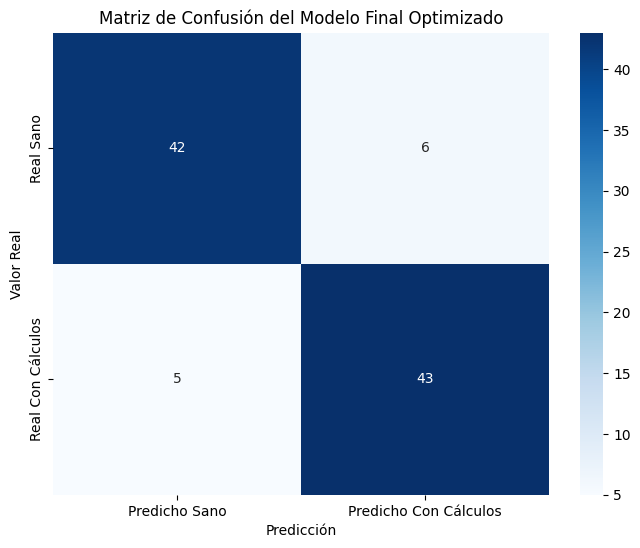


--- Resumen Final Comparativo de Métricas ---


,Estrategia,Test Accuracy,Test AUC
1,GB Optimizado (SMOTE + Optuna),0.8854,0.9280
0,Mejor Benchmark (XGBoost),0.8542,0.9015


In [10]:
# --- 7. ESTRATEGIA AVANZADA: SMOTE + OPTUNA ---
print("\n--- Estrategia de Mejora: Aumento de Datos con SMOTE y Búsqueda con Optuna ---")

# 1. Aplicar SMOTE al conjunto de entrenamiento seleccionado por ANOVA
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_selected, y_train)
print(f"Tamaño del conjunto de entrenamiento original: {X_train_selected.shape}")
print(f"Tamaño del conjunto de entrenamiento tras SMOTE: {X_train_smote.shape}\n")

# 2. Definir la función objetivo para Optuna
mejor_modelo_nombre = resultados_benchmark_df.iloc[0]['Modelo']
print(f"Optimizando hiperparámetros para el mejor modelo del benchmark: {mejor_modelo_nombre}")

def objective(trial):
    # Optimizar para Gradient Boosting, que es robusto y suele mejorar mucho.
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000, log=True),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 2, 32),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0)
    }
    model = GradientBoostingClassifier(random_state=42, **params)
    score = cross_val_score(model, X_train_smote, y_train_smote, n_jobs=-1, cv=5, scoring='accuracy').mean()
    return score

# 3. Ejecutar el estudio de Optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50, show_progress_bar=True)

print(f"\nMejores hiperparámetros encontrados: {study.best_params}")

# 4. Entrenar y evaluar el modelo final optimizado
final_model_optuna = GradientBoostingClassifier(random_state=42, **study.best_params)
final_model_optuna.fit(X_train_smote, y_train_smote)

y_pred_optuna = final_model_optuna.predict(X_test_selected)
y_proba_optuna = final_model_optuna.predict_proba(X_test_selected)[:, 1]

optuna_accuracy = accuracy_score(y_test, y_pred_optuna)
optuna_auc = roc_auc_score(y_test, y_proba_optuna)

### **Celda 9: Análisis y Comparación Final**
# --- 8. ANÁLISIS Y COMPARACIÓN FINAL ---

print(f"--- Análisis Detallado del Modelo Final Optimizado (GBM + SMOTE + Optuna) ---")
print("\nReporte de Clasificación en el conjunto de prueba:")
print(classification_report(y_test, y_pred_optuna, target_names=['Sano (0)', 'Con Cálculos (1)']))

# Matriz de Confusión
cm = confusion_matrix(y_test, y_pred_optuna)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicho Sano', 'Predicho Con Cálculos'], yticklabels=['Real Sano', 'Real Con Cálculos'])
plt.title('Matriz de Confusión del Modelo Final Optimizado')
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.show()

# Resumen Comparativo
print("\n--- Resumen Final Comparativo de Métricas ---")
mejor_modelo_benchmark_nombre = resultados_benchmark_df.iloc[0]['Modelo']
accuracy_base = resultados_benchmark_df.iloc[0]['Test Accuracy']
auc_base = resultados_benchmark_df.iloc[0]['Test AUC']

summary_data = {
    "Estrategia": [
        f"Mejor Benchmark ({mejor_modelo_benchmark_nombre})",
        "GB Optimizado (SMOTE + Optuna)"
    ],
    "Test Accuracy": [f"{accuracy_base:.4f}", f"{optuna_accuracy:.4f}"],
    "Test AUC": [f"{auc_base:.4f}", f"{optuna_auc:.4f}"]
}
summary_df = pd.DataFrame(summary_data)
display(summary_df.sort_values(by='Test Accuracy', ascending=False))


--- ¿Qué características (seleccionadas por ANOVA) son más importantes para el modelo final? ---

Gráfico de Importancia de Características SHAP (Bar Plot):
Muestra el impacto promedio absoluto de cada característica en la predicción.


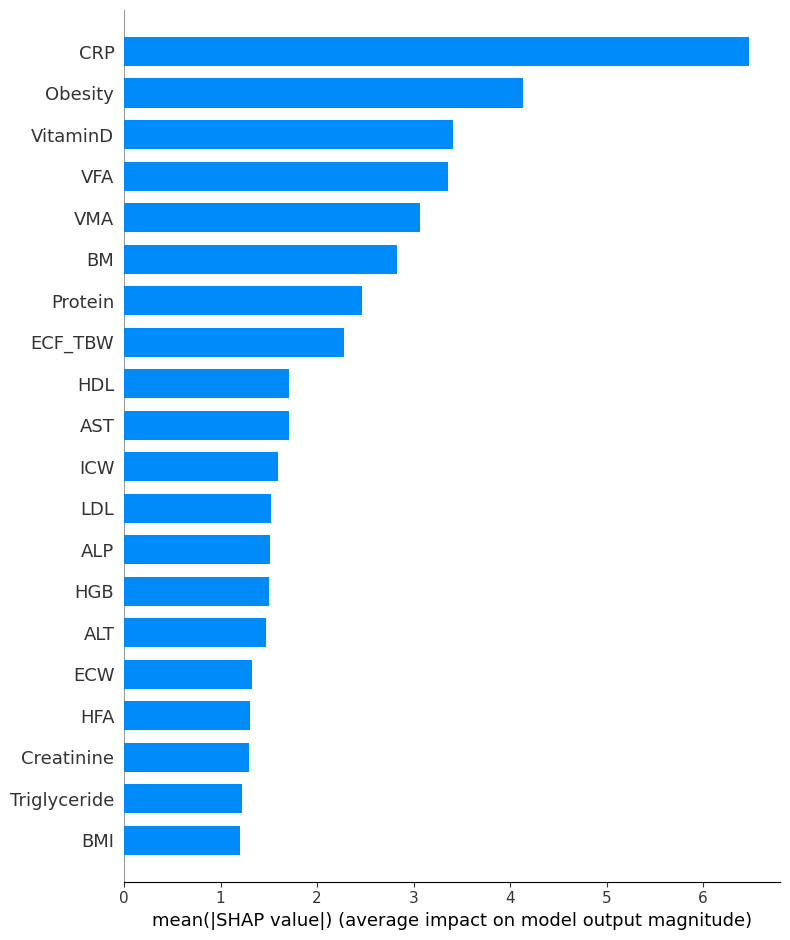


Gráfico de Resumen de SHAP (Beeswarm):
Muestra el impacto de cada característica para cada paciente.
- Eje X: Valor SHAP (impacto en la predicción. >0 aumenta la prob. de tener cálculos).
- Color: Valor de la característica (rojo=alto, azul=bajo).


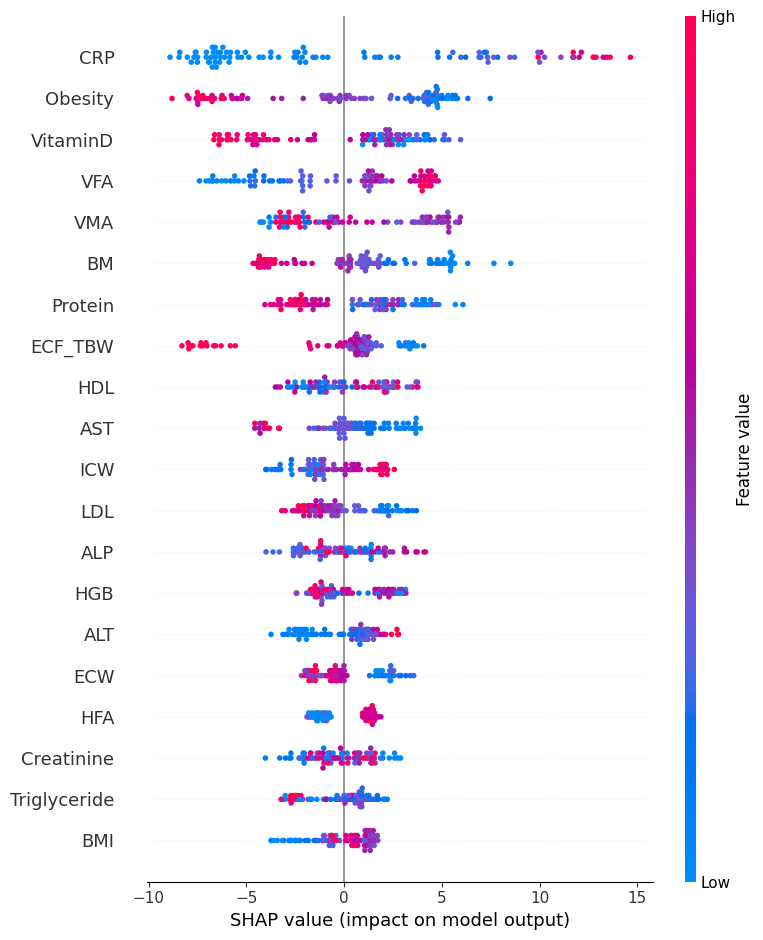

In [11]:
# --- 9. INTERPRETABILIDAD DEL MODELO FINAL CON SHAP ---
print("\n--- ¿Qué características (seleccionadas por ANOVA) son más importantes para el modelo final? ---")

# El explainer se crea a partir del modelo final
explainer = shap.TreeExplainer(final_model_optuna)

# Se calculan los valores SHAP sobre el conjunto de prueba (seleccionado)
# Se añade check_additivity=False para evitar el error de precisión.
shap_values = explainer.shap_values(X_test_selected, check_additivity=False)

# SHAP necesita que los datos para los gráficos sean un DataFrame para mostrar los nombres de las columnas
X_test_selected_df = pd.DataFrame(X_test_selected, columns=selected_features_names)

print("\nGráfico de Importancia de Características SHAP (Bar Plot):")
print("Muestra el impacto promedio absoluto de cada característica en la predicción.")
shap.summary_plot(shap_values, X_test_selected_df, plot_type='bar')

print("\nGráfico de Resumen de SHAP (Beeswarm):")
print("Muestra el impacto de cada característica para cada paciente.")
print("- Eje X: Valor SHAP (impacto en la predicción. >0 aumenta la prob. de tener cálculos).")
print("- Color: Valor de la característica (rojo=alto, azul=bajo).")
shap.summary_plot(shap_values, X_test_selected_df)